In [1]:
import glob
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [3]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(r"C:\Users\denis\PycharmProjects\recsys-course-spring-2025\rec_sys_data\week_2\*\data.json")
])
data["rnd"] = np.random.random(len(data))

data.head(10)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2025-02-27 09:42:49.930,8281,49401,1.00,0.003750,35042.0,{'STICKY_ARTIST': 'C'},0.374540
1,next,2025-02-27 09:42:49.935,1119,15722,1.00,0.001238,12090.0,{'STICKY_ARTIST': 'T1'},0.950714
2,next,2025-02-27 09:42:49.991,8281,35042,0.40,0.000776,12244.0,{'STICKY_ARTIST': 'C'},0.731994
3,next,2025-02-27 09:42:49.993,6424,26035,0.80,0.000820,31575.0,{'STICKY_ARTIST': 'T8'},0.598658
4,next,2025-02-27 09:42:50.041,1119,21000,0.64,0.001121,15722.0,{'STICKY_ARTIST': 'T1'},0.156019
5,next,2025-02-27 09:42:50.043,3518,37574,0.64,0.000933,32796.0,{'STICKY_ARTIST': 'T4'},0.155995
6,next,2025-02-27 09:42:50.091,6424,13035,0.51,0.000908,31557.0,{'STICKY_ARTIST': 'T8'},0.058084
7,next,2025-02-27 09:42:50.100,8281,36956,0.05,0.000667,38928.0,{'STICKY_ARTIST': 'C'},0.866176
8,next,2025-02-27 09:42:50.140,1119,15722,0.00,0.000852,19816.0,{'STICKY_ARTIST': 'T1'},0.601115
9,next,2025-02-27 09:42:50.149,8281,38928,0.07,0.000466,36243.0,{'STICKY_ARTIST': 'C'},0.708073


## Compute track popularity

In [4]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,24435,4.1
1,47647,3.6
2,18461,3.0
3,25688,3.0
4,45642,3.0


In [5]:
len(track_popularity)

11256

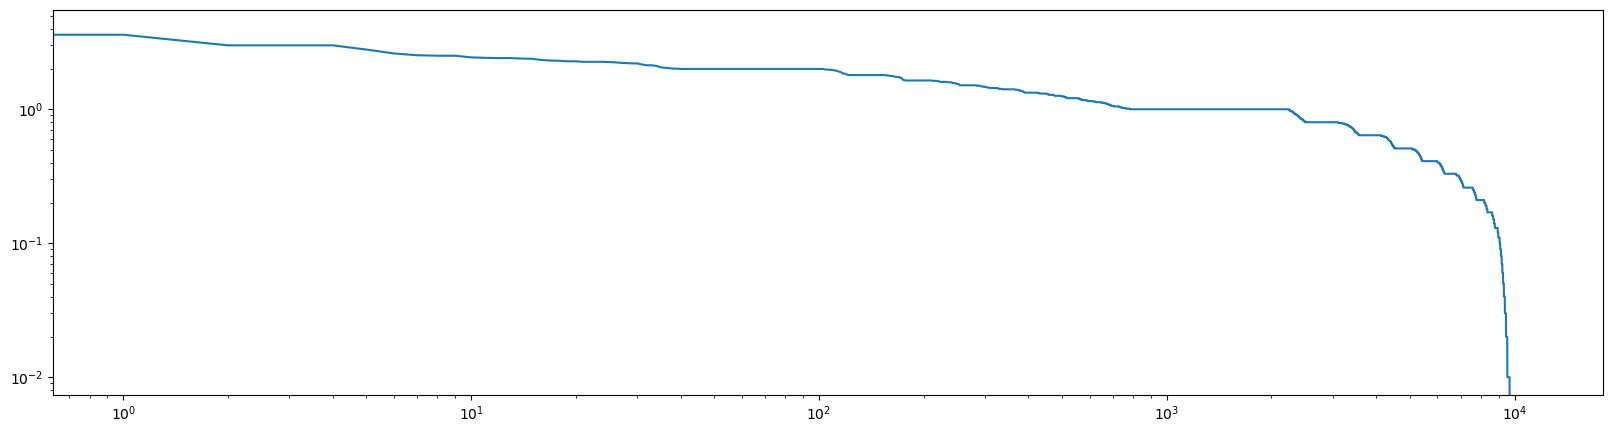

In [6]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

ax.set_xscale("log")
ax.set_yscale("log")

pass

## Compute offline metrics

In [10]:
# recommendations - список рекомендованных track id от лучшего к худшему
# track           - id трека, который выбрал пользователь
# k               - k в precision@K


def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [11]:
tracks = track_popularity["track"].tolist()

t_p_10 = lambda track: precision_at(tracks, track, 10)
st_10_p_10 = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10 = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10 = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_PrecAt10"] = metrics["track"].map(t_p_10)
metrics["shuffledTop10_PrecAt10"] = metrics["track"].map(st_10_p_10)
metrics["shuffledTop100_PrecAt10"] = metrics["track"].map(st_100_p_10)
metrics["shuffledTop1000_PrecAt10"] = metrics["track"].map(st_1000_p_10)

metrics[["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe()

,top10_PrecAt10,shuffledTop10_PrecAt10,shuffledTop100_PrecAt10,shuffledTop1000_PrecAt10
count,3150.000000,3150.000000,3150.000000,3150.000000
mean,0.000032,0.000032,0.000032,0.000063
std,0.001782,0.001782,0.001782,0.002519
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


In [12]:
def mrr(recommendations, track):
    return 1.0 / (1 + recommendations.index(track)) if track in recommendations else 0.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [13]:
tracks = track_popularity["track"].tolist()

t_mrr = lambda track: mrr(tracks, track)
st_10_mrr = lambda track: shuffled_mrr(tracks[:10], track)
st_100_mrr = lambda track: shuffled_mrr(tracks[:100], track)
st_1000_mrr = lambda track: shuffled_mrr(tracks[:1000], track)

metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_mrr"] = metrics["track"].map(t_mrr)
metrics["shuffledTop10_mrr"] = metrics["track"].map(st_10_mrr)
metrics["shuffledTop100_mrr"] = metrics["track"].map(st_100_mrr)
metrics["shuffledTop1000_mrr"] = metrics["track"].map(st_1000_mrr)

metrics[["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe()

,top10_mrr,shuffledTop10_mrr,shuffledTop100_mrr,shuffledTop1000_mrr
count,3150.000000,3150.000000,3150.000000,3150.000000
mean,0.000355,0.000063,0.000309,0.000935
std,0.003595,0.003563,0.006122,0.026020
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000116,0.000000,0.000000,0.000000
max,0.166667,0.200000,0.250000,1.000000


## Export data for prod

In [14]:
with open(r"C:\Users\denis\PycharmProjects\recsys-course-spring-2025\botify\data\top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)

In [15]:
track_popularity["track"].tolist()

[24435,
 47647,
 18461,
 25688,
 45642,
 36879,
 5033,
 12054,
 23204,
 8231,
 36433,
 13897,
 23604,
 16814,
 8790,
 12715,
 18055,
 14779,
 20940,
 19004,
 4335,
 16894,
 22396,
 28548,
 44487,
 15551,
 19888,
 44700,
 15722,
 21382,
 32148,
 18627,
 37222,
 38413,
 43562,
 3961,
 26435,
 17816,
 12407,
 21292,
 17809,
 33936,
 916,
 34334,
 17957,
 22805,
 5513,
 18409,
 42617,
 42215,
 43020,
 2451,
 26667,
 32868,
 6200,
 26520,
 27398,
 21447,
 21940,
 41726,
 31079,
 30623,
 23007,
 9557,
 25323,
 25316,
 17149,
 36622,
 12198,
 40617,
 33911,
 18295,
 5168,
 26011,
 15871,
 15900,
 14004,
 38644,
 38746,
 3656,
 49171,
 29695,
 22885,
 45000,
 20735,
 21319,
 42160,
 30461,
 10441,
 2193,
 29334,
 19486,
 28507,
 19848,
 37952,
 24089,
 4668,
 15796,
 14775,
 15157,
 4085,
 13415,
 42839,
 38164,
 12254,
 17878,
 23979,
 32103,
 12090,
 47019,
 8905,
 11273,
 17737,
 13625,
 45854,
 20514,
 9846,
 37331,
 23790,
 33644,
 26487,
 31009,
 1526,
 27894,
 7049,
 9444,
 24525,
 4022